# CSCA 5622: Introduction To Machine Learning: Supervised Learning Final Assignment

**NOTE: RUN THIS CODE BEFORE READING ANYTHING!**

### Imports

In [19]:
# imports
from enum import Enum
import json
import requests
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

### Global variables / Enums

In [20]:
# static, global variables
GOMPERTZ_MAX = 150 # maximum age possible by the gompert equation
STATCAN_URL = 'https://www150.statcan.gc.ca/t1/wds/rest/getDataFromCubePidCoordAndLatestNPeriods'

# enums for API calls
class Gender(Enum):
    MALE = 'male'
    FEMALE = 'female'
    BOTH = 'both'
    
class dataPIDs(Enum):
    LIFEEXP = 13100837 # table num
    
class dataCoords(Enum):
    LIFEEXP_BOTH = '1.1.1.8.0.0.0.0.0.0' # Canada, age 0, both sexes, Life expectancy
    LIFEEXP_MALE = '1.1.2.8.0.0.0.0.0.0' # Canada, age 0, male, Life expectancy
    LIFEEXP_FEMALE = '1.1.3.8.0.0.0.0.0.0' # Canada, age 0, female, Life expectancy

### Data Collection / Cleaning

In [21]:
# API calls to StatCan to get our data, and return it in JSON format
def getJSONFromURL(url, pid, coordinate, period):
    payload = [{'productId': pid,
            'coordinate': coordinate,
            'latestN': period}]
    headers = {'Content-Type': 'application/json', 'Accept': 'application/json'}
    
    # call getDataFromVectorAndLatestNPeriods to get the amount of data points via metadata
    # POST insead of GET because we are sending data
    response = requests.post(url, json=payload, headers=headers)
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f'Error: {response.status_code}')
        print(response.text)
        return None

# Gets our data from the API callback, and converts it into 2 arrays based on gender and years of data requested
def get_life_expectancy_data(gender: Gender, years_back=40):
    if gender == Gender.MALE:
        coord = dataCoords.LIFEEXP_MALE.value
    elif gender == Gender.FEMALE:
        coord = dataCoords.LIFEEXP_FEMALE.value
    else:
        coord = dataCoords.LIFEEXP_BOTH.value
        
    data = getJSONFromURL(STATCAN_URL, dataPIDs.LIFEEXP.value, coord, years_back)
    
    dates = []
    values = []
    
    for vec in data[0]['object']['vectorDataPoint']:
        date = vec['refPer']
        value = vec['value']
        numpy_date = datetime.strptime(date, '%Y-%m-%d').year
        dates.append(numpy_date)
        values.append(float(value))
        
    return dates, values

### Regression Algorithm

In [22]:
def predict_life_expectancy(age=0, gender=Gender.BOTH, years_back=40, model_data=False):
    '''
    Predict life expectancy based on age, gender, and 
    
    age (int): current age of the person
    gender (Gender)
    years_back (int): Years of historical data to use
    model_data (bool): whether to show model data
    '''
    # Get life expec data
    dates, values = get_life_expectancy_data(gender, years_back)
    
    X = np.array(dates).reshape(-1, 1)
    y = np.array(values)
    
    # Create Weights (reduce COVID impact)
    weights = np.ones(len(dates))
    covid_years = [2020, 2021, 2022]
    for i, year in enumerate(dates):
        if year in covid_years:
            weights[i] = 0.05 # 5%
        
    # model building, poly regression (poly features + linear regression)
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_poly, y, sample_weight=weights)
    
    # Make base prediction based on cur year
    current_year = datetime.now().year
    X_future = poly.transform(np.array([[current_year]]))
    base_prediction = model.predict(X_future)[0]
    
    # Adjust for cur age
    if age > 0:
        remaining_years = base_prediction - age
    else:
        remaining_years = base_prediction
    
    # Gender-specific adjustments (gender trend)
    if gender == Gender.FEMALE:
        remaining_years += 2
    elif gender == Gender.MALE:
        remaining_years -= 2
    
    # clamp btwn 0 and the max age scientists have discovered humans could live for 
    final_prediction = max(0, min(remaining_years, GOMPERTZ_MAX)) 
    
    if (model_data):
        print(f"Model Performance for {years_back} of data related to {gender}:")
        print(f"R2 Score: {r2_score(y, model.predict(X_poly))}")
    
    return final_prediction

Github Repo for this Project: https://github.com/reeeeemo/LifeExpectancy

## What is this Project?
---
This is a project that takes a user's current age, and gender (optional), and outputs their predicted life expectancy.

#### What is the algorithm / task?
---
This uses a **Polynomial Regression** algorithm, that is fit upon data gained from **Statistics Canada** about [Life Expectancy across Canada](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1310083701)

This algorithm also uses weights to lessen the impact of COVID-19 for the years of 2020-2022, for more accuracy.

#### Why create another Life Expectancy Algorithm?
---
I actually used this in a larger project (unrelated to my final assignment), you can find it [here](https://github.com/reeeeemo/GBLC). This project took your age, gender, and initial investment, and returned a inflation-adjusted return when you invest into Canadian government bonds over your lifespan.

This project used this algorithm alongside 2 targeted monte-carlo simulations to create predictions for the future life expectancy, inflation, and government bond prices in Canada.

**Why only Polynomial Regression for this assignment then?**
It was a great experience to come back to multi-linear regression and explore polynomial regression a little deeper. I felt like I only scratched the surface of what it was, and after this course I explored the idea of modifying the algorithm to get a more accurate result!

## Data: Source and Uses

#### StatCan Info
---
As stated previously, the data was gained from **Statistics Canada** about [Life Expectancy across Canada](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1310083701).

StatCan, the official statistics website for the Government of Canada, allows use of their data via API calls. You can find more info about how to call their API [here](https://www.statcan.gc.ca/en/developers/wds).

One thing you should see with the data, is that female life expectancy is notably higher than male. "Both" is just a median between the two (Male and Female). The good news is that there is an upward trend in life expectancy!

#### StatCan Data Use
---
To summarize, to properly call the dataset I wanted,  I did not want to train my algorithm on **ALL** of the data StatCan had to offer. After all, life expectancy has rapidly increased with the addition of new technologies and medical advancements.

I chose *40 years* as the length of data I was going to take. Why 40 exactly?
- Decently relevant to modern medical trends / conditions
- Significant increase in $R^2$ scores (**20 years:** 0.88 for male and 0.92 for female, **40 years:** 0.98 and 0.99 for female and male)
- Not overfitting the data (**60 years:** no difference between 40 years), but also not too sensitive.

Run the code below to see the $R^2$ scores:

In [23]:
# 20 years back:
age_35_male = predict_life_expectancy(60, Gender.MALE, 20, True)
age_35_female = predict_life_expectancy(60, Gender.FEMALE, 20, True)
print("")
# 40 years back:
age_35_male = predict_life_expectancy(60, Gender.MALE, 40, True)
age_35_female = predict_life_expectancy(60, Gender.FEMALE, 40, True)
# 60 years back:
print("")
age_35_male = predict_life_expectancy(60, Gender.MALE, 60, True)
age_35_female = predict_life_expectancy(60, Gender.FEMALE, 60, True)

Model Performance for 20 of data related to Gender.MALE:
R2 Score: 0.885749947395076
Model Performance for 20 of data related to Gender.FEMALE:
R2 Score: 0.9292720413799721

Model Performance for 40 of data related to Gender.MALE:
R2 Score: 0.9922131161545934
Model Performance for 40 of data related to Gender.FEMALE:
R2 Score: 0.9852423874721645

Model Performance for 60 of data related to Gender.MALE:
R2 Score: 0.9907744998277533
Model Performance for 60 of data related to Gender.FEMALE:
R2 Score: 0.9830748634315596


You might be thinking: "But what about Cross-Validation?!", that doesn't really apply to this specific problem. We are using this algorithm to **predict current/future life expectancy**, not classify historical patterns.

#### Data Cleaning / Size
---
The data comes mostly clean, **HOWEVER**, the fact that a catastrophe such as COVID-19 (2020-2022) that could cause life expectancy to increase or decrease at an abnormal rate has to be omitted from the algorithm, as we are not looking to predict another catastrophe, just life expectancy.

All this means is adding **weights** to our regression algorithm, so we can tell the algorithm that we only want the COVID-19 years to be accounted for around 5% of what a normal year's life expectancy is worth. 

The code to showcase the weighted approach, and the size of our data is listed below:

In [24]:
# Gets JSON data from our API callback, based on gender and years worth of data (its quite long, no need to read it all)
gender = Gender.BOTH
years_back = 40

if gender == Gender.MALE:
    coord = dataCoords.LIFEEXP_MALE.value
elif gender == Gender.FEMALE:
    coord = dataCoords.LIFEEXP_FEMALE.value
else:
    coord = dataCoords.LIFEEXP_BOTH.value
        
data = getJSONFromURL(STATCAN_URL, dataPIDs.LIFEEXP.value, coord, years_back)
    
print(json.dumps(data, indent=2))

[
  {
    "status": "SUCCESS",
    "object": {
      "responseStatusCode": 0,
      "productId": 13100837,
      "coordinate": "1.1.1.8.0.0.0.0.0.0",
      "vectorId": 1300144478,
      "vectorDataPoint": [
        {
          "refPer": "1984-01-01",
          "refPer2": "",
          "refPerRaw": "1984-01-01",
          "refPerRaw2": "",
          "value": 76.36,
          "decimals": 2,
          "scalarFactorCode": 0,
          "symbolCode": 0,
          "statusCode": 0,
          "securityLevelCode": 0,
          "releaseTime": "2022-01-24T08:30",
          "frequencyCode": 12
        },
        {
          "refPer": "1985-01-01",
          "refPer2": "",
          "refPerRaw": "1985-01-01",
          "refPerRaw2": "",
          "value": 76.35,
          "decimals": 2,
          "scalarFactorCode": 0,
          "symbolCode": 0,
          "statusCode": 0,
          "securityLevelCode": 0,
          "releaseTime": "2022-01-24T08:30",
          "frequencyCode": 12
        },
        {

In [25]:
# Size of data, alongisde the range of dates and the previous life expectancies we get from our JSON parsing.
dates = []
values = []
    
for vec in data[0]['object']['vectorDataPoint']:
    date = vec['refPer']
    value = vec['value']
    numpy_date = datetime.strptime(date, '%Y-%m-%d').year
    dates.append(numpy_date)
    values.append(float(value))
    
# Create Weights (reduce COVID impact)
weights = np.ones(len(dates))
covid_years = [2020, 2021, 2022]
for i, year in enumerate(dates):
    if year in covid_years:
        weights[i] = 0.05 # 5%
        
print(f"\nSize of dates: {len(dates)}")
print(f"Size of values: {len(values)}")
print(f"Date Range: {min(dates)} to {max(dates)}")
print(f"\nWeight Range: {min(weights)} (COVID Impact) to {max(weights)} (Normal Year)")


Size of dates: 40
Size of values: 40
Date Range: 1984 to 2023

Weight Range: 0.05 (COVID Impact) to 1.0 (Normal Year)


In [26]:
# Life Expectancy stats for all genders
male_dates, male_values = get_life_expectancy_data(Gender.MALE, 40)
female_dates, female_values = get_life_expectancy_data(Gender.FEMALE, 40)

male_stats = {
    'Mean': np.mean(male_values),
    'Median': np.median(male_values),
    'Std Dev': np.std(male_values),
    'Min': np.min(male_values),
    'Max': np.max(male_values)
}

female_stats = {
    'Mean': np.mean(female_values),
    'Median': np.median(female_values),
    'Std Dev': np.std(female_values),
    'Min': np.min(female_values),
    'Max': np.max(female_values)
}

print("Male Life Expec Stats:")
for stat, value in male_stats.items():
    print(f"{stat}: {value:.2f}")
    
print("\nFemale Life Expec Stats:")
for stat, value in female_stats.items():
    print(f"{stat}: {value:.2f}")

Male Life Expec Stats:
Mean: 77.09
Median: 77.50
Std Dev: 2.35
Min: 73.01
Max: 80.11

Female Life Expec Stats:
Mean: 82.27
Median: 82.33
Std Dev: 1.45
Min: 79.80
Max: 84.32


As we can see with the data, there is a **notable gap between male and female life expectancy rates**, let's take a closer look at the gap.

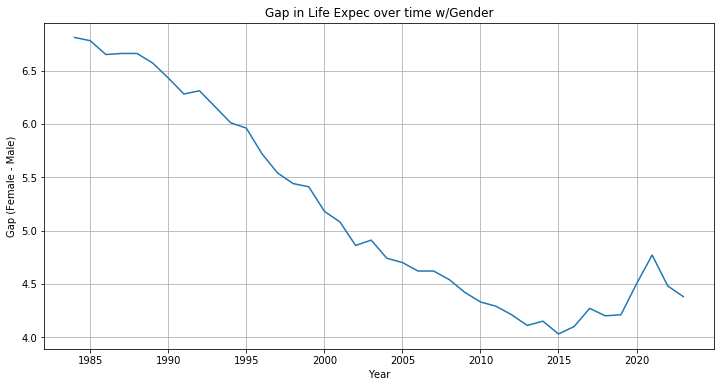

In [27]:
# Gap between Life Expec data graphed for both genders
gender_gap = [f - m for f, m in zip(female_values, male_values)]

plt.figure(figsize=(12,6))
plt.plot(male_dates, gender_gap)
plt.title("Gap in Life Expec over time w/Gender")
plt.xlabel("Year")
plt.ylabel("Gap (Female - Male)")
plt.grid(True)
plt.show()

In [28]:
from scipy import stats

slope, intercept, r_val, p_val, std_err = stats.linregress(male_dates, gender_gap)

print(f"\nTrend Analysis of gap between genders:")
print(f"Slope: {slope:.4f} years per year")
print(f"R-Squared: {r_val**2:.4f}")
print(f"P-Value: {p_val:.4f}")


Trend Analysis of gap between genders:
Slope: -0.0749 years per year
R-Squared: 0.8683
P-Value: 0.0000


### EDA Findings
- Since we have `p < 0.001`, it could very well mean that the difference between genders when it comes to life expec is statistically significant, and not just random variation.

- The gender gap is also decreasing gradually `-0.0749 per year`, however Females still consistently have a higher life expec.

- Since our $R^2$ is pretty large: `R-Squared: 0.8683`, we can prove that there is a trend that can explain the change in our gender gap.
    - Note that this $R^2$ is different from our previous $R^2$ value, we are not using our polynomial model to predict life expectancy, just proving the trend in our gender gap.

## Model Equation
---

$$ LFE = \beta_{0} + \beta_{1}(Age) + \beta_{2}(Gender) + \epsilon $$

When originally working on this model, the first idea was to use a **Linear Regression** model, as a base. However, the relationship between the data isn't exactly linear.

So, what do we do? Add a multi-linear regression model instead! More specifically, a **Polynomial Regression** model.

However, just starting there doesn't cut it, we need to take a good look at *degree* we want for our regression model!

In [29]:
from sklearn.model_selection import train_test_split

# Finding the degree that fits our regression model best.
years_back = 40
gender = Gender.BOTH
degrees = 10

# Get our data!
dates, values = get_life_expectancy_data(gender, years_back)
    
X = np.array(dates).reshape(-1, 1)
y = np.array(values)
    
# create our weights, to reduce the covid-19 impact
weights = np.ones(len(dates))
covid_years = [2020, 2021, 2022]
for i, year in enumerate(dates):
    if year in covid_years:
        weights[i] = 0.05 # 5%

# get our data from train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model building, polynomial regression (poly features + linear regression)
for i in range(1, degrees):
    poly = PolynomialFeatures(degree=i)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    train_score = r2_score(y_train, model.predict(X_train_poly))
    test_score = r2_score(y_test, model.predict(X_test_poly))
    
    print(f"\nDegree {i}:")
    print(f"Training R2: {train_score:.4f}")
    print(f"Testing R2: {test_score:.4f}")
    print(f"Difference: {abs(train_score - test_score):.4f}")
    



Degree 1:
Training R2: 0.9448
Testing R2: 0.9023
Difference: 0.0426

Degree 2:
Training R2: 0.9738
Testing R2: 0.9517
Difference: 0.0220

Degree 3:
Training R2: 0.9924
Testing R2: 0.9930
Difference: 0.0006

Degree 4:
Training R2: 0.9924
Testing R2: 0.9931
Difference: 0.0007

Degree 5:
Training R2: 0.9925
Testing R2: 0.9932
Difference: 0.0007

Degree 6:
Training R2: 0.9925
Testing R2: 0.9932
Difference: 0.0007

Degree 7:
Training R2: 0.9926
Testing R2: 0.9933
Difference: 0.0007

Degree 8:
Training R2: 0.9926
Testing R2: 0.9933
Difference: 0.0007

Degree 9:
Training R2: 0.9927
Testing R2: 0.9934
Difference: 0.0007


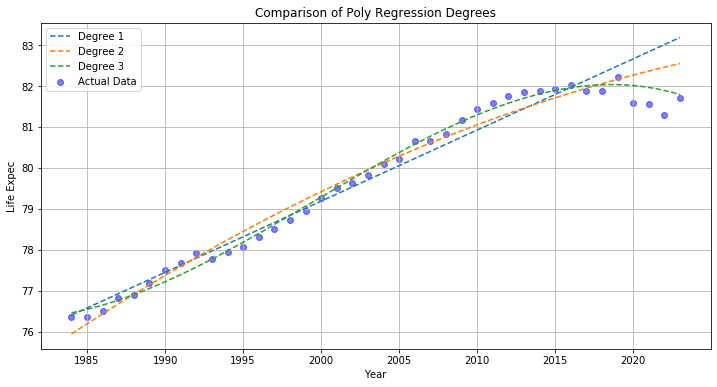

In [30]:
# setup our plot
plt.figure(figsize=(12,6))

plt.scatter(dates, values, color='blue', alpha=0.5, label='Actual Data')

for deg in [1, 2, 3]:
    poly = PolynomialFeatures(degree=deg)
    X_poly = poly.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_poly, y, sample_weight=weights)
    
    X_smooth = np.linspace(min(dates), max(dates), 200).reshape(-1, 1)
    X_smooth_poly = poly.transform(X_smooth)
    y_smooth = model.predict(X_smooth_poly)
    
    plt.plot(X_smooth, y_smooth, label=f'Degree {deg}', linestyle='--')
    
plt.title("Comparison of Poly Regression Degrees")
plt.xlabel('Year')
plt.ylabel('Life Expec')
plt.legend()
plt.grid(True)
plt.show()

As you can see, the difference between Degree 3 and Degree 4 are extremely small (in the graph, they would be on top of each other), which means it might be overfitting the data. 

The difference between 2 and 3 is also quite a large jump (in the graph it is fitting to the trend, but taking only 5% of what the COVID years would be), which is good. So we have our degree now! `Degree = 3`

## Model Adjustments, summarized
---

- (`degree=3`) Since we get an optimal fit (`$R^2$ = 0.99`) without overfitting (and since `degree=2` shows gaps, and `degree>3` shows overfitting
- Females get `+2` years to their age, since historically they have a higher life expectancy (the gender trend we saw earlier), and Males get `-2` years for the same reason
- COVID-19 years (2020-2022) are weighted at 5% importance, since catastrophes should not be included in our regression algorithm (might cause a downward trend in our data)

In [32]:
def predict_life_expectancy(age=0, gender=Gender.BOTH, years_back=40, model_data=False):
    '''
    Predict life expectancy based on age, gender, and 
    
    age (int): current age of the person
    gender (Gender)
    years_back (int): Years of historical data to use
    model_data (bool): whether to show model data
    '''
    # Get our life expec data
    dates, values = get_life_expectancy_data(gender, years_back)
    
    X = np.array(dates).reshape(-1, 1)
    y = np.array(values)
    
    # Create Weights (reduce COVID impact)
    weights = np.ones(len(dates))
    covid_years = [2020, 2021, 2022]
    for i, year in enumerate(dates):
        if year in covid_years:
            weights[i] = 0.05 # 5%
        
    # model building, polynomial regression (poly features + linear regression)
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_poly, y, sample_weight=weights)
    
    # Make base prediction based on current year
    current_year = datetime.now().year
    X_future = poly.transform(np.array([[current_year]]))
    base_prediction = model.predict(X_future)[0]
    
    # Adjust for current age
    if age > 0:
        remaining_years = base_prediction - age
    else:
        remaining_years = base_prediction
    
    # Gender-specific adjustments (gender trend!)
    if gender == Gender.FEMALE:
        remaining_years += 2
    elif gender == Gender.MALE:
        remaining_years -= 2
    
    # clamp between 0 and the max age scientists have discovered humans could live for
    final_prediction = max(0, min(remaining_years, GOMPERTZ_MAX)) 
    
    # performance variables
    if (model_data):
        print(f"Model Performance for {years_back} of data related to {gender}:")
        print(f"R2 Score: {r2_score(y, model.predict(X_poly))}")
    
    return final_prediction

### Predictions, real world data
---

It's time to show off our algorithm, we will take 4 ages: `[0, 15, 45, 65]`, and showcase each life expectancy for someone who is currently that age, in our current year.

In [33]:
ages = [0, 15, 45, 65]

print("Current Life Expec Predictions:")
print("-" * 40)
for age in ages:
    for gender in Gender:
        pred = predict_life_expectancy(age, gender)
        print(f"{gender.value.capitalize()} at {age}: {pred:.1f} more years")
    print("-" * 40)

Current Life Expec Predictions:
----------------------------------------
Male at 0: 77.4 more years
Female at 0: 86.0 more years
Both at 0: 81.7 more years
----------------------------------------
Male at 15: 62.4 more years
Female at 15: 71.0 more years
Both at 15: 66.7 more years
----------------------------------------
Male at 45: 32.4 more years
Female at 45: 41.0 more years
Both at 45: 36.7 more years
----------------------------------------
Male at 65: 12.4 more years
Female at 65: 21.0 more years
Both at 65: 16.7 more years
----------------------------------------


## Conclusion
---


Overall this project was extremely entertaining to write, if you compared the life_expectancy from my [larger project](https://github.com/reeeeemo/GBLC) to here, you'd see it differs quite a bit now. 

Other than the obvious custom-written LinearRegression and PolynomialFeatures (Vercel's free app can't download Scikit-learn, too large), the degree is actually `2`. Through this final project, and data testing, I learnt that the optimal degree is actually `3`. Pretty cool, huh?

I did mention the *maximum age possible for a human being*, which was 150 (on the optimistic end). You can find an academic journal [here](https://pubmed.ncbi.nlm.nih.gov/34035236/) with the proof of that.

The largest obstacle with this project, was learning the trends of human life expectancy in Canada, and noticing how biological gender matters when it comes to life expectancy. I experimented with a lot of percentiles for the COVID weights as well, and anywhere above 5% causes a **downward trend** in the life expectancy data, which doesn't make much sense for a normal year.